In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
import json
import time
import os
import tensorflow as tf
import tensorflow_probability as tfp
import pickle
import string

tfd = tfp.distributions

InteractiveShell.ast_node_interactivity = 'all'
%config InlineBackend.figure_format = 'retina'


In [196]:
data_size = 'large'
x_train = np.load(f'../shakespeare_data/{data_size}_dataset/x_train.npy')
y_train = np.load(f'../shakespeare_data/{data_size}_dataset/y_train.npy')
gid_train = np.load(f'../shakespeare_data/{data_size}_dataset/gid_train.npy')
gid2_train = np.load(f'../shakespeare_data/{data_size}_dataset/gid2_train.npy')
x_test = np.load(f'../shakespeare_data/{data_size}_dataset/x_test.npy')
y_test = np.load(f'../shakespeare_data/{data_size}_dataset/y_test.npy')
gid_test = np.load(f'../shakespeare_data/{data_size}_dataset/gid_test.npy')
gid2_test = np.load(f'../shakespeare_data/{data_size}_dataset/gid2_test.npy')

In [197]:
user_info = pd.read_pickle('../shakespeare_data/user_info.pickle')

In [198]:
user_info.head()

,play,num_samples_train,num_samples_test,user_id,play_id
user,,,,,
TWELFTH_NIGHT__OR__WHAT_YOU_WILL_SECOND_OFFICER,"TWELFTH NIGHT; OR, WHAT YOU WILL",13,2,1124,35
THE_TRAGEDY_OF_CORIOLANUS_FIRST_LORD,THE TRAGEDY OF CORIOLANUS,334,38,819,25
THE_FIRST_PART_OF_HENRY_THE_SIXTH_COUNTESS,THE FIRST PART OF HENRY THE SIXTH,1736,193,393,13
THE_TRAGEDY_OF_JULIUS_CAESAR_ARTEMIDORUS,THE TRAGEDY OF JULIUS CAESAR,639,72,884,27
THE_SECOND_PART_OF_KING_HENRY_THE_SIXTH_WARWICK,THE SECOND PART OF KING HENRY THE SIXTH,5184,576,664,20


In [91]:
# groups = np.unique(gid_train)
# train_idx = np.where(gid_train == gid)[0]
# test_idx = np.where(gid_train == gid)[0]

# large_dict = {
#         gid: [x_train[train_idx], y_train[train_idx], 
#               x_test[test_idx], y_test[test_idx], 
#               gid_train[train_idx], gid_test[test_idx]]
#         for gid 
#         in groups
#     }

large_dict={}
for gid in groups:
    train_idx = np.where(gid_train == gid)[0]
    test_idx = np.where(gid_test == gid)[0]
    large_dict[gid] = [x_train[train_idx], y_train[train_idx], 
             x_test[test_idx], y_test[test_idx], 
             gid_train[train_idx], gid_test[test_idx]]

In [199]:
writer_df = pd.DataFrame(np.stack([y_train.flatten(), gid_train]).T, 
                         columns=['label', 'writer'])
distribution_of_labels = writer_df.groupby('writer')['label'].value_counts().unstack().fillna(0)
samples_per_writer = writer_df.groupby('writer').size().rename('num_train_samples')
samples_weights = samples_per_writer.transform(lambda x: x/x.sum())

In [200]:
directories = !cd ../experiments/shakespeare; ls -d -- */
directories = directories[-3:]

In [201]:
directories

['2019-08-05_03-51-53/', '2019-08-05_05-44-29/', '2019-08-05_08-58-27/']

In [11]:
directories = ['2019-07-22_05-33-52_lr_0.001_batch-size_200_num-epochs_10_data-size_large_model-size_large_z-dim_20_latent_True_concatdense_True_variational_True_seed_None_/',
 '2019-07-22_05-35-57_lr_0.0001_batch-size_200_num-epochs_10_data-size_large_model-size_large_z-dim_20_latent_True_concatdense_True_variational_True_seed_None_/',
 '2019-07-22_05-37-29_lr_0.001_batch-size_200_num-epochs_10_data-size_large_model-size_large_z-dim_20_latent_False_concatdense_True_variational_True_seed_None_/',
 '2019-07-22_05-38-48_lr_0.001_batch-size_200_num-epochs_20_data-size_large_model-size_large_z-dim_10_latent_True_concatdense_True_variational_True_seed_None_/']

In [202]:
results_df_list = []
hyperparams = []
mod_hyperparams = []
for exp_dir in directories:
    exp_path = os.path.join('..','experiments', 'shakespeare', exp_dir)
    
    # Merge training stats csv's
    training_stats_files = !cd {exp_path}; ls -d -- training_stats*
    df_list = []
    for file in training_stats_files:
        df_list.append(pd.read_csv(os.path.join(exp_path, file)))
    df = pd.concat(df_list)
    df = df.set_index(['epoch', 'gid'])
    results_df_list.append(df)
    
    # load hyperparam json file
    with open(os.path.join(exp_path, 'hyperparams.json'),'r') as f:
        hyper = json.load(f)
        mod_hyper = hyper.copy()
        hyperparams.append(hyper)
        # Need this so can groupby later
        mod_hyper['z_dim'] = str(mod_hyper['z_dim'])
        if mod_hyper['seed'] is None:
            mod_hyper['seed']=-1
        if mod_hyper['description'] is None:
            mod_hyper['description']=-1
        mod_hyperparams.append(mod_hyper)
    
config_df = pd.concat((pd.Series(param_dict) for param_dict in mod_hyperparams), axis=1).T

In [203]:
config_df

,batch_size,both,data_size,dataset,description,eval_every,latent_config,latent_space,lr,model_size,num_epochs,print_freq,seed,testing,variational,z_dim
0,1000,False,large,shakespeare,trying shakespeare,1,none,False,0.004,large,10,20,24,False,False,[0]
1,1000,False,large,shakespeare,trying shakespeare,1,factor,True,0.004,large,6,20,24,False,True,"[16, 8]"
2,1000,False,large,shakespeare,trying shakespeare,1,double,True,0.004,large,6,20,24,False,True,"[16, 8, 16, 8]"


In [38]:
num_configs = len(directories)
plt.figure(figsize=(12,num_configs*4))

temp = config_df.drop(['seed','testing', 'print_freq', 'tag'],1)
# Move description to end
display(temp[[col for col in temp if col not in ['description']] + ['description']])

for i in range(num_configs):
    train_stats = results_df_list[i]
    fed_acc_df = train_stats['test_acc'].unstack()
    
    plt.subplot(num_configs,2,2*i+1)
    fed_acc_df.tail(1).squeeze().hist(bins=20)
    plt.title('Distribution of local accuracy across characters in last epoch')
    plt.xlabel('Test accuracy')

    print('Taking 50 percentile bc didnt want to deal with nans')
    stats = [
        #np.mean(fed_acc_df.tail(1).squeeze().values),
        round(np.dot(fed_acc_df.tail(1).squeeze().values, samples_weights.values),3),  
        #round(np.percentile(sorted(fed_acc_df.tail(1).squeeze().dropna().values), 50),3),
        round(np.percentile(sorted(fed_acc_df.tail(1).squeeze().dropna().values), 10),3),
        round(np.percentile(sorted(fed_acc_df.tail(1).squeeze().dropna().values), 90),3)]
    print('Weighted test accuracy: {}, 10th percentile: {}, 90th percentile: {}'.format(*stats))

    plt.subplot(num_configs,2,2*i+2)
    #plt.plot(fed_dict['global_accuracy_per_round'], c='C0')
    plt.plot(fed_acc_df.apply(lambda s: np.percentile(s.dropna(), 50), axis=1).values)
    # plt.plot(fed_acc_df.apply(lambda s: np.percentile(s, 10), axis=1).values)
    plt.fill_between(range(len(fed_acc_df)), 
                     fed_acc_df.apply(lambda s: np.percentile(s.dropna(), 90), axis=1).values,
                     fed_acc_df.apply(lambda s: np.percentile(s.dropna(), 10), axis=1).values,
                     alpha=0.1, facecolor='C0')

    plt.fill_between(range(len(fed_acc_df)), 
                     fed_acc_df.apply(lambda s: np.percentile(s.dropna(), 75), axis=1).values,
                     fed_acc_df.apply(lambda s: np.percentile(s.dropna(), 25), axis=1).values,
                     alpha=0.2, facecolor='C0')

    plt.title('Test accuracy across epochs\n'
              'distributed across writers')
    plt.xlabel('Epochs')
    plt.ylabel('Test accuracy')

plt.tight_layout();

KeyError: "['tag'] not found in axis"

<Figure size 864x864 with 0 Axes>

,batch_size,both,data_size,dataset,eval_every,latent_config,latent_space,lr,model_size,num_epochs,variational,z_dim,description
0,1000,False,large,shakespeare,1,none,False,0.004,large,10,False,[0],trying shakespeare
1,1000,False,large,shakespeare,1,factor,True,0.004,large,6,True,"[16, 8]",trying shakespeare
2,1000,False,large,shakespeare,1,double,True,0.004,large,6,True,"[16, 8, 16, 8]",trying shakespeare


Config 0: test accuracy = 0.598, 50th percentile = 0.6, 10th percentile = 0.508, 90th percentile = 0.686
Config 1: test accuracy = 0.592, 50th percentile = 0.596, 10th percentile = 0.5, 90th percentile = 0.684
Config 2: test accuracy = 0.592, 50th percentile = 0.594, 10th percentile = 0.514, 90th percentile = 0.678


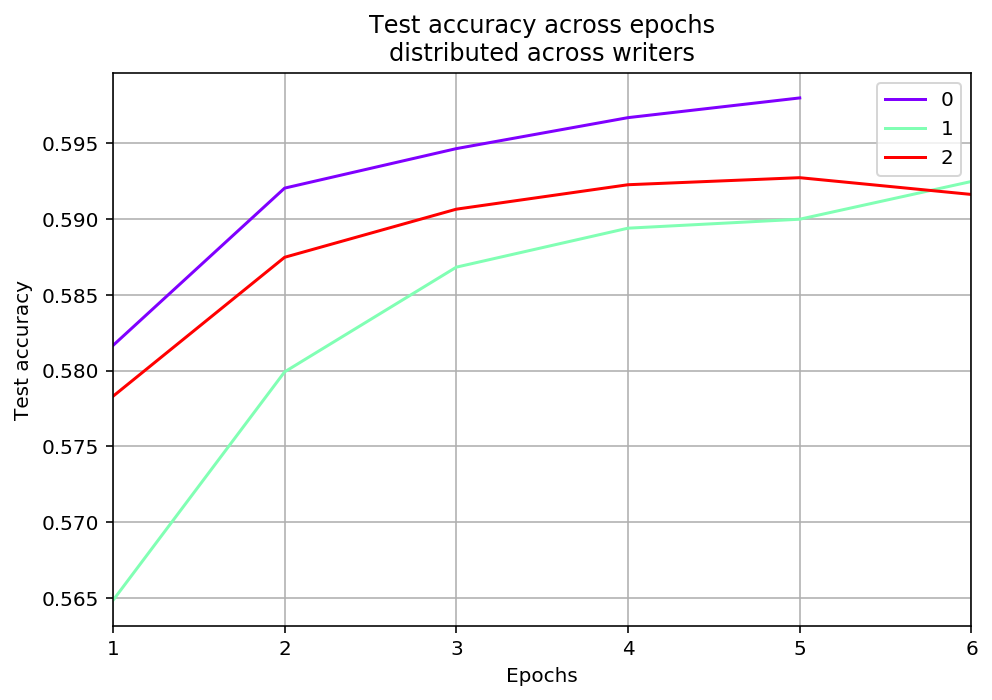

In [204]:
num_configs = len(directories)

temp = config_df.drop(['seed', 'testing', 'print_freq'],1)
# Move description to end
display(temp[[col for col in temp if col not in ['description']] + ['description']])

mean_accs = []
for i in range(num_configs):
    train_stats = results_df_list[i]
    fed_acc_df = train_stats['test_acc'].unstack()
    mean_acc = fed_acc_df.apply(lambda s: np.dot(s.values, samples_weights.values), axis=1)
    mean_accs.append(mean_acc)

    get_percentile = lambda perc: np.percentile(
        sorted(fed_acc_df.tail(1).squeeze().dropna().values), perc)
    stats = [
        round(np.dot(fed_acc_df.tail(1).squeeze().values, samples_weights.values),3),
        round(get_percentile(50),3),
        round(get_percentile(10),3),
        round(get_percentile(90),3)]
    print('Config {}: test accuracy = {}, 50th percentile = {}, 10th percentile = {}, 90th percentile = {}'.format(i, *stats))
    
ax = pd.concat(mean_accs, axis=1).plot(figsize=(7,5), cmap='rainbow')
#for i in range(4):
#    pd.concat(mean_accs, axis=1).reset_index().plot.scatter(x='epoch', y=i,figsize=(7,5), ax=ax)
plt.title('Test accuracy across epochs\ndistributed across writers')
plt.xlabel('Epochs')
plt.ylabel('Test accuracy')
plt.grid(True)
plt.tight_layout();

In [40]:
def inner_transpose(df):
    return df.stack().swaplevel(i=-2, j=-1).unstack()

hyper_df = (
    config_df
    .rename_axis(index='config')
    .reset_index()
    .groupby(['config'] + list(config_df.columns))
    # query the results dataframe from config_df_list
    # dropping the index so all the evaluated epochs line up 
    # TODO: maybe change this
    .apply(lambda df: results_df_list[df['config'].values[0]]['test_acc'].unstack()))

In [41]:
hyper_df.loc[0].head()

gid                                                                                                                                                                                         0   \
batch_size both  data_size dataset     description        eval_every latent_config latent_space lr    model_size num_epochs print_freq seed testing variational z_dim          epoch             
1000       False small     shakespeare trying shakespeare 1          none          False        0.004 large      3          10         24   False   False       [16, 8, 16, 8] 1      0.333333   
                                                                                                                                                                               2      0.500000   
                                                                                                                                                                               3      0.500000   

gid                                                                                                                                                                                         1   \
batch_size both  data_size dataset     description        eval_every latent_config latent_space lr    model_size num_epochs print_freq seed testing variational z_dim          epoch             
1000       False small     shakespeare trying shakespeare 1          none          False        0.004 large      3          10         24   False   False       [16, 8, 16, 8] 1      0.431373   
                                                                                                                                                                               2      0.549020   
                                                                                                                                                                               3      0.607843   

gid                                                                                                                                                                                         2   \
batch_size both  data_size dataset     description        eval_every latent_config latent_space lr    model_size num_epochs print_freq seed testing variational z_dim          epoch             
1000       False small     shakespeare trying shakespeare 1          none          False        0.004 large      3          10         24   False   False       [16, 8, 16, 8] 1      0.478328   
                                                                                                                                                                               2      0.538700   
                                                                                                                                                                               3      0.568885   

gid                                                                                                                                                                                         3   \
batch_size both  data_size dataset     description        eval_every latent_config latent_space lr    model_size num_epochs print_freq seed testing variational z_dim          epoch             
1000       False small     shakespeare trying shakespeare 1          none          False        0.004 large      3          10         24   False   False       [16, 8, 16, 8] 1      0.411765   
                                                                                                                                                                               2      0.529412   
                                                                                                                                                                               3      0.588235   

gid                                                                                                                 

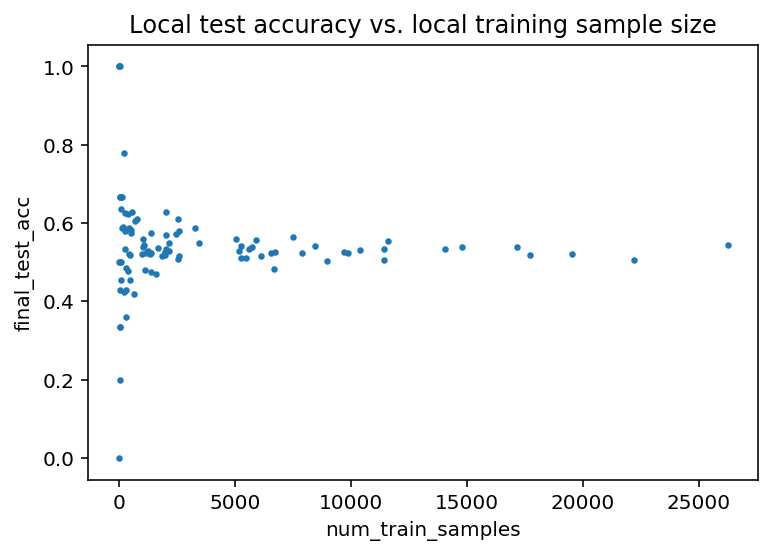

In [43]:
config_num = 2
pd.concat([inner_transpose(hyper_df).loc[config_num][2].reset_index(drop=True).rename('final_test_acc'), 
           samples_per_writer], axis=1).plot.scatter(x='num_train_samples', y='final_test_acc', s=5)
plt.title('Local test accuracy vs. local training sample size');

In [44]:
config_num = 2

with open(os.path.join('../experiments/shakespeare', directories[config_num], 'model_weights.pickle'), 'rb') as f:
    model_weights=pickle.load(f)

In [45]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/Users/milesturpin/latent_variable_nn')
sys.path.insert(1, '/Users/milesturpin/latent_variable_nn/models')
from lstm import LatentLSTM
import argparse

args = argparse.Namespace()
args_dict = vars(args)
args_dict.update(hyperparams[config_num])

opt = tf.keras.optimizers.Adam(1e-3)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
latent3000 = LatentLSTM(
    opt, loss_fn, [len(np.unique(gid_train)), len(np.unique(gid2_train))], 
    args, experiment_dir=None, logger=None)
latent3000(x_train[:2], gid_train[:2].astype(np.int32), gid2_train[:2])
latent3000.set_weights(model_weights);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
score = accuracy_score(
    shuffle(y_test, random_state=3)[:1000], 
    latent3000(shuffle(x_test, random_state=3)[:1000], 
               shuffle(gid_test, random_state=3)[:1000], 
               shuffle(gid2_test, random_state=3)[:1000]).numpy().argmax(axis=1))

In [59]:
# TODO: zero out the weights or latent vectors and see how performance changes

In [58]:
print(score)

0.572


In [129]:
pd.Series(shuffle(y_test, random_state=3)[:10000].flatten()).value_counts().shape

(50,)

In [141]:
'oee'.find('e')

1

In [148]:
x_test[:1].flatten().astype(int).dtype

dtype('int64')

In [151]:
x_test[:1].shape

(1, 80)

In [193]:
input_string = ''.join(list(map(lambda x: labels[x], x_test[101:102].flatten().astype(int))))
preds = []
in_sent = x_test[:1]
for i in range(20):
    letter_pred_idx = latent3000(in_sent, gid_test[101:102], gid2_test[101:102]).numpy().argmax(axis=1)
    letter_pred = labels[letter_pred_idx.astype(int)[0]]
    preds.append(letter_pred)
    next_input = np.concatenate([in_sent[:,1:], np.array([letter_pred_idx])], axis=1)
input_string + ''.join(preds)

'hall outwear three years  No woman may approach his silent court  Therefore to sAAAAIIATATTAAAIWAAAT'

In [138]:
latent3000(x_test[:1],gid_test[:1], gid2_test[:1])

<tf.Tensor: id=99479, shape=(1, 53), dtype=float32, numpy=
array([[2.3329366e-02, 8.4085703e-02, 3.0473236e-02, 4.0483763e-03,
        8.3902171e-03, 2.2142742e-02, 1.7747017e-02, 9.0349885e-03,
        2.5522402e-02, 1.5957426e-01, 1.2018118e-03, 1.4470451e-03,
        8.7565733e-03, 3.3398911e-02, 2.2562170e-02, 4.3954495e-02,
        4.0364759e-03, 1.7538600e-04, 2.1269061e-03, 4.9129445e-02,
        8.5487284e-02, 4.0292568e-03, 2.6260477e-03, 9.2509307e-02,
        1.1783841e-05, 2.5833508e-02, 5.0556468e-05, 7.0679948e-02,
        1.6489986e-02, 4.4181715e-03, 2.5813289e-03, 7.4531836e-04,
        1.2167673e-02, 5.5572758e-03, 8.5576801e-03, 6.7274948e-03,
        5.2956504e-05, 6.3678215e-04, 4.6886653e-03, 1.1266617e-02,
        6.2265606e-03, 6.0088392e-03, 3.2482361e-03, 9.5692108e-04,
        1.0464586e-03, 2.1514652e-02, 3.1390455e-02, 1.6629009e-03,
        8.8554888e-04, 1.3656644e-02, 2.3505785e-05, 7.1216598e-03,
        2.4093715e-06]], dtype=float32)>

In [132]:
short_y = shuffle(y_test, random_state=3)[:10000]
short_pred = latent3000(shuffle(x_test, random_state=3)[:10000], 
               shuffle(gid_test, random_state=3)[:10000], 
               shuffle(gid2_test, random_state=3)[:10000]).numpy().argmax(axis=1)
conf_mtx = confusion_matrix(short_y, short_pred)

In [104]:
y_train.shape

(361015, 1)

In [112]:
import string

In [115]:
labels = ' ' + string.ascii_uppercase + string.ascii_lowercase

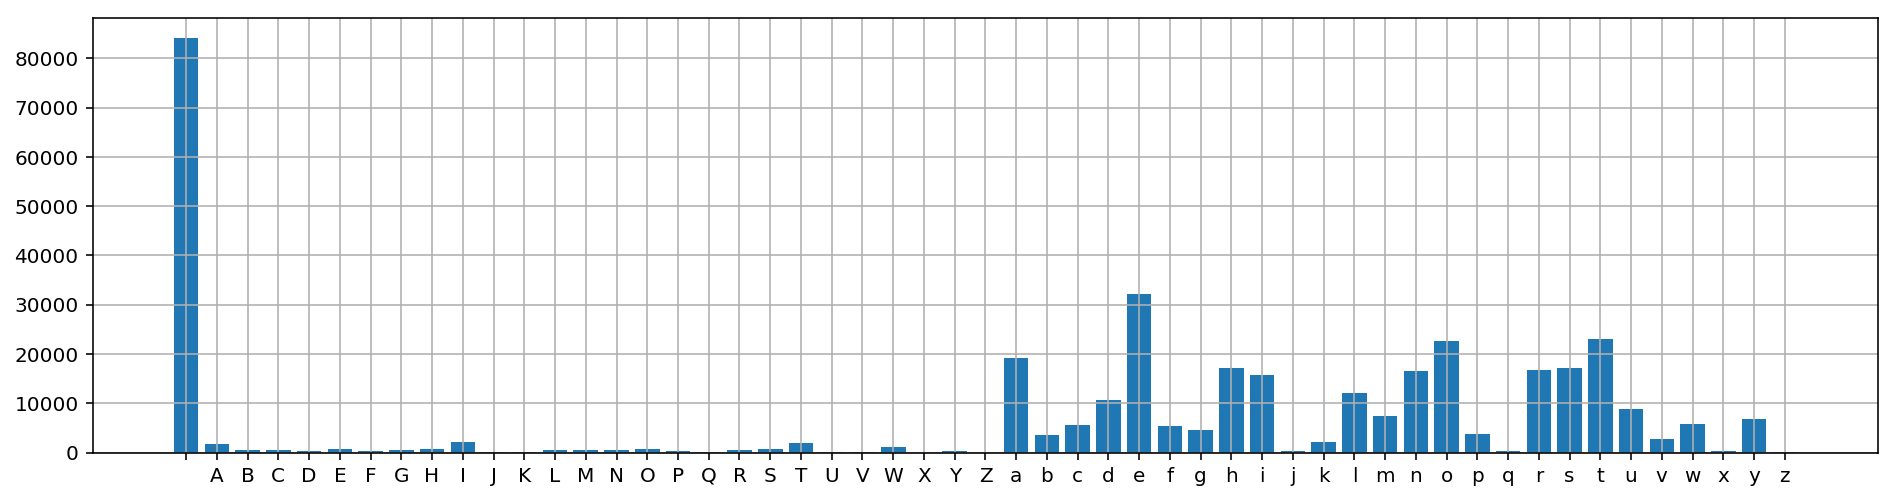

In [117]:
y_counts = pd.Series(y_train.flatten()).value_counts().sort_index().values
plt.figure(figsize=(16,4))
plt.grid()
plt.bar(range(53), y_counts)
plt.xticks(ticks=range(53), labels=labels);

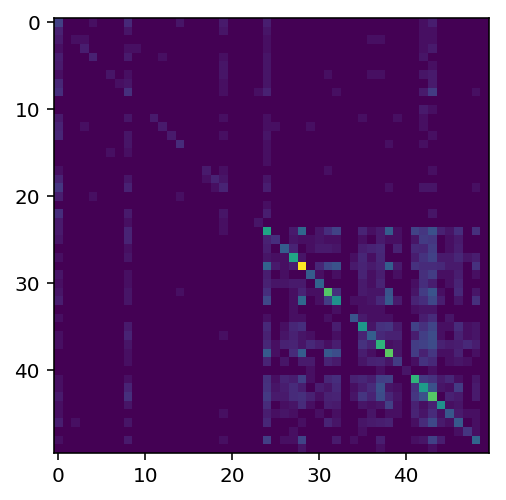

In [130]:
plt.imshow(np.sqrt(conf_mtx[1:,1:]+0.001))

In [122]:
conf_mtx.shape

(44, 44)

In [121]:
# trying to get the letter that is most mistaken
(conf_mtx - np.diag(np.diag(conf_mtx))).sum(axis=0).shape

(44,)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

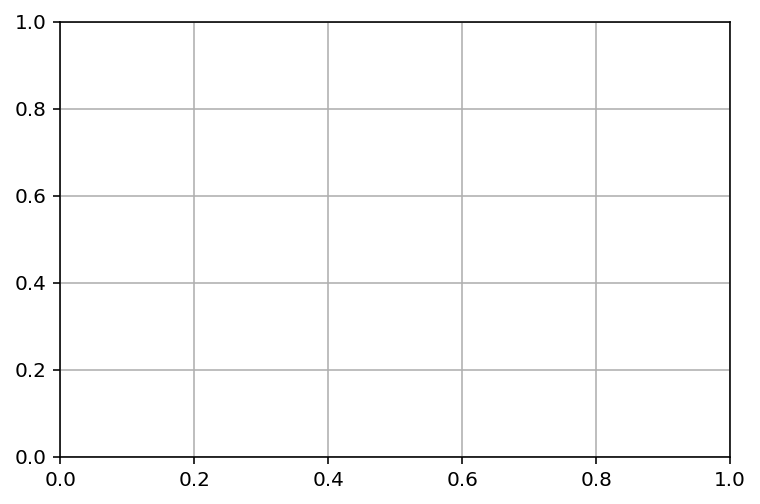

In [120]:
plt.grid()
plt.bar(range(53), (conf_mtx - np.diag(np.diag(conf_mtx))).sum(axis=0))
plt.xticks(ticks=range(53), labels=labels);


In [46]:
latent3000.summary()

Model: "latent_lstm_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  6784      
_________________________________________________________________
lstm_2 (LSTM)                multiple                  394240    
_________________________________________________________________
lstm_3 (LSTM)                multiple                  525312    
_________________________________________________________________
dense_2 (Dense)              multiple                  71936     
_________________________________________________________________
dense_3 (Dense)              multiple                  14893     
Total params: 1,019,405
Trainable params: 1,019,405
Non-trainable params: 0
_________________________________________________________________


In [47]:
[x.shape for x in latent3000.trainable_weights]

[TensorShape([53, 128]),
 TensorShape([128, 1024]),
 TensorShape([256, 1024]),
 TensorShape([1024]),
 TensorShape([256, 1024]),
 TensorShape([256, 1024]),
 TensorShape([1024]),
 TensorShape([280, 256]),
 TensorShape([256]),
 TensorShape([280, 53]),
 TensorShape([53]),
 TensorShape([96, 16]),
 TensorShape([96, 16]),
 TensorShape([3, 8]),
 TensorShape([3, 8]),
 TensorShape([96, 16]),
 TensorShape([96, 16]),
 TensorShape([3, 8]),
 TensorShape([3, 8])]

In [60]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_mu = pca.fit_transform(latent3000.z_mu.numpy())
pca = PCA(n_components=2)
pca_sigma = pca.fit_transform(latent3000.z_sigma.numpy())

In [62]:
from sklearn.decomposition import PCA
pca2 = PCA(n_components=2)
pca_mu2 = pca.fit_transform(latent3000.z2_mu.numpy())
pca2 = PCA(n_components=2)
pca_sigma2 = pca.fit_transform(latent3000.z2_sigma.numpy())

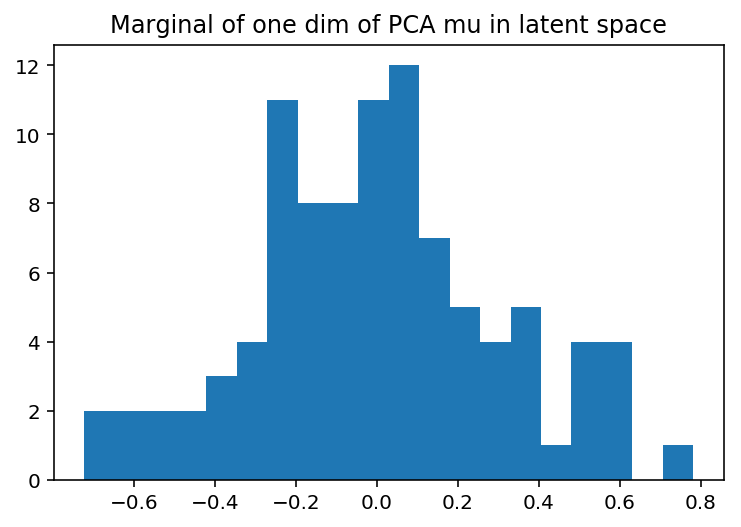

In [61]:
plt.hist(pca_mu[:,0], bins=20)
plt.title('Marginal of one dim of PCA mu in latent space');

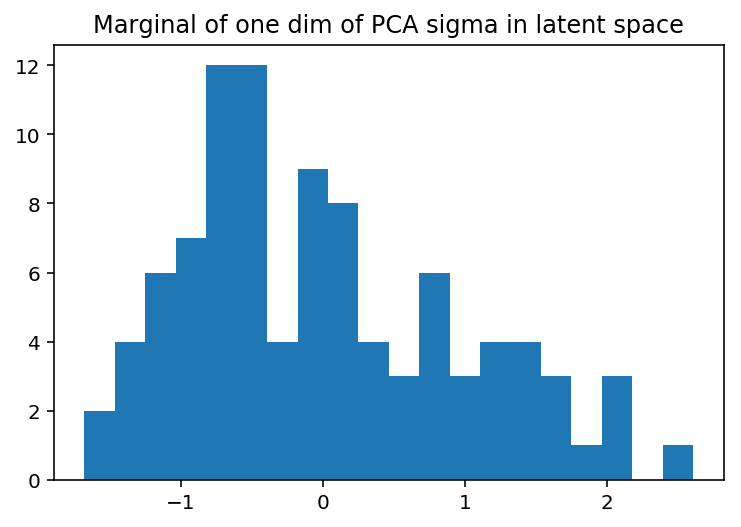

In [63]:
plt.hist(pca_sigma[:,0], bins=20)
plt.title('Marginal of one dim of PCA sigma in latent space');

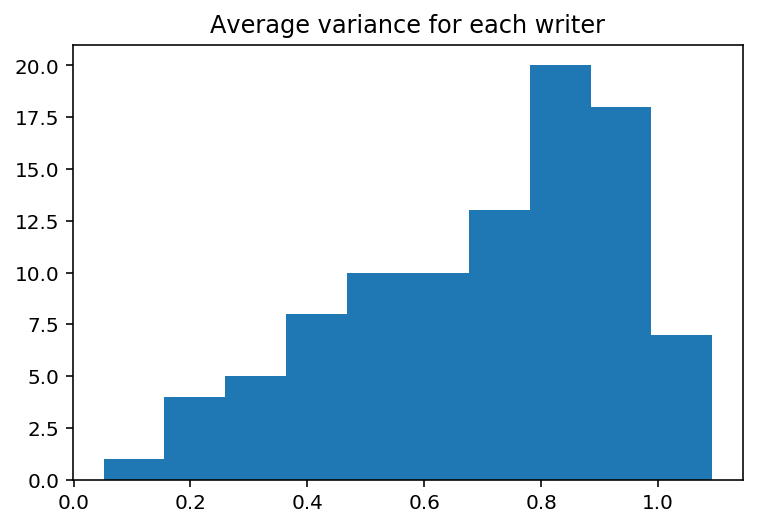

In [64]:
plt.hist(latent3000.z_sigma.numpy().mean(axis=1))
plt.title('Average variance for each writer');

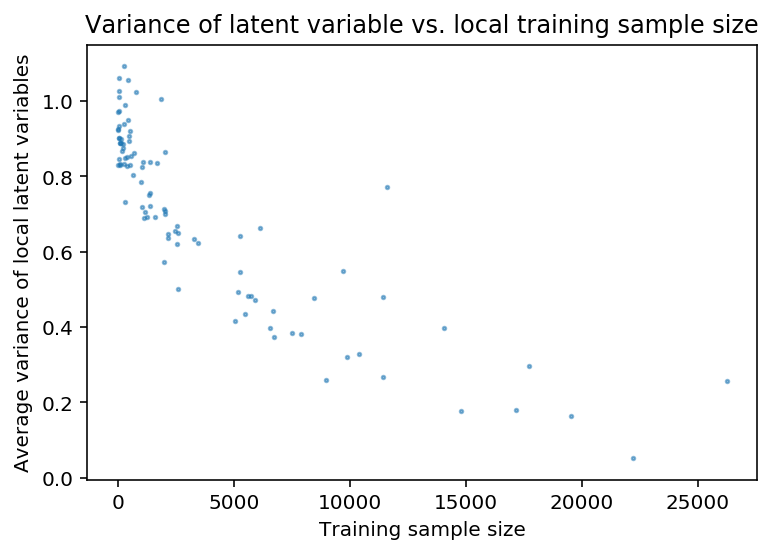

In [65]:
plt.scatter(samples_per_writer.values, 
            latent3000.z_sigma.numpy().mean(axis=1),
            s=3, alpha=0.5
            )
plt.xlabel('Training sample size')
plt.ylabel('Average variance of local latent variables')
plt.title('Variance of latent variable vs. local training sample size');

### latent var 1

In [77]:
from sklearn.mixture import GaussianMixture

mix = GaussianMixture(n_components=1, covariance_type='full')
mix.fit(latent3000.z_mu.numpy())

mix_dist = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=mix.weights_),
    #components_distribution=tfd.MultivariateNormalDiag(
    #    loc=mix.means_, scale_identity_multiplier=mix.covariances_)
    #components_distribution=tfd.MultivariateNormalDiag(
    #    loc=mix.means_, scale_diag=mix.covariances_)
    components_distribution=tfd.MultivariateNormalFullCovariance(
loc=mix.means_, covariance_matrix=mix.covariances_));

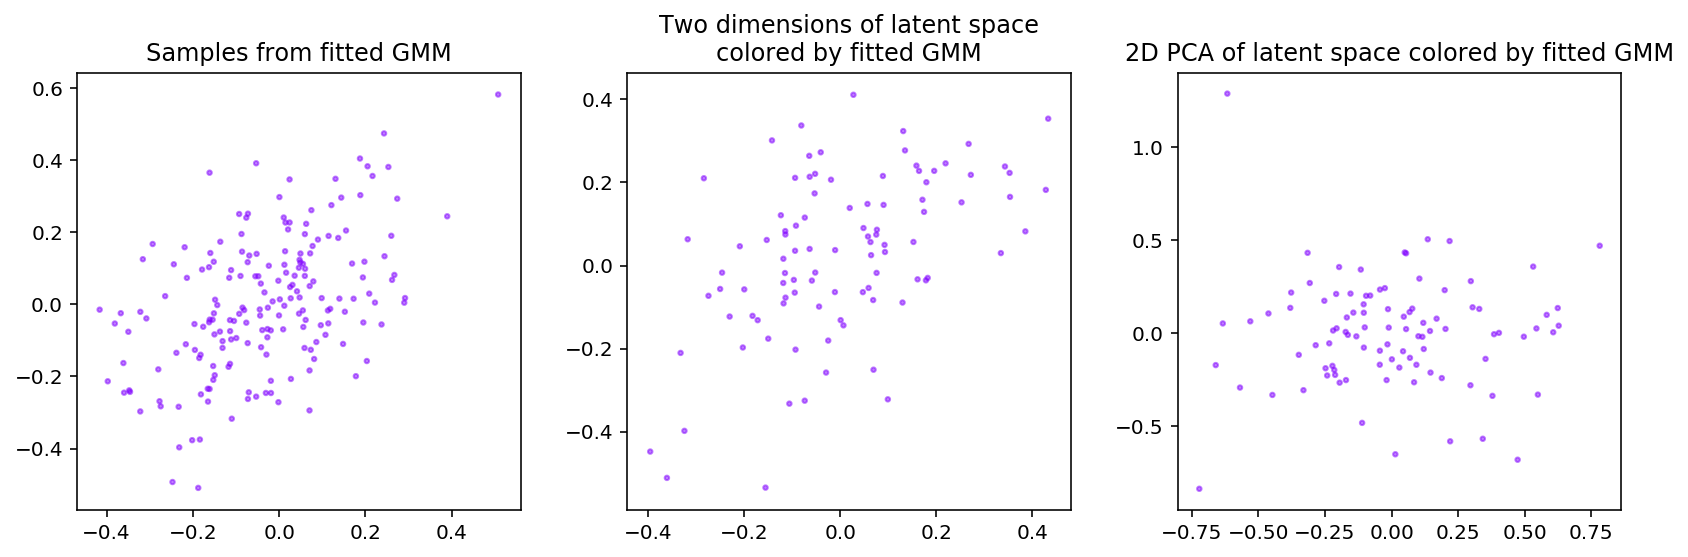

In [78]:
plt.figure(figsize=(12,4))
plt.subplot(131)

mix_samp = mix_dist.sample(190)
assign_samp = tfd.Categorical(probs=mix.predict_proba(mix_samp)).sample().numpy()

plt.scatter(mix_samp[:,1], mix_samp[:,2], s=5, 
           c=assign_samp, cmap='rainbow', alpha=0.5)
plt.title('Samples from fitted GMM')

plt.subplot(132)
z_space = latent3000.z_mu.numpy()
assign_samp = tfd.Categorical(probs=mix.predict_proba(z_space)).sample().numpy()
plt.scatter(z_space[:,1], z_space[:,2], s=5, 
           c=assign_samp, cmap='rainbow', alpha=0.5)
plt.title('Two dimensions of latent space\ncolored by fitted GMM')

plt.subplot(133)
z_space = pca_mu
plt.scatter(z_space[:,0], z_space[:,1], s=5, 
           c=assign_samp, cmap='rainbow', alpha=0.5)
plt.title('2D PCA of latent space colored by fitted GMM')
plt.tight_layout();

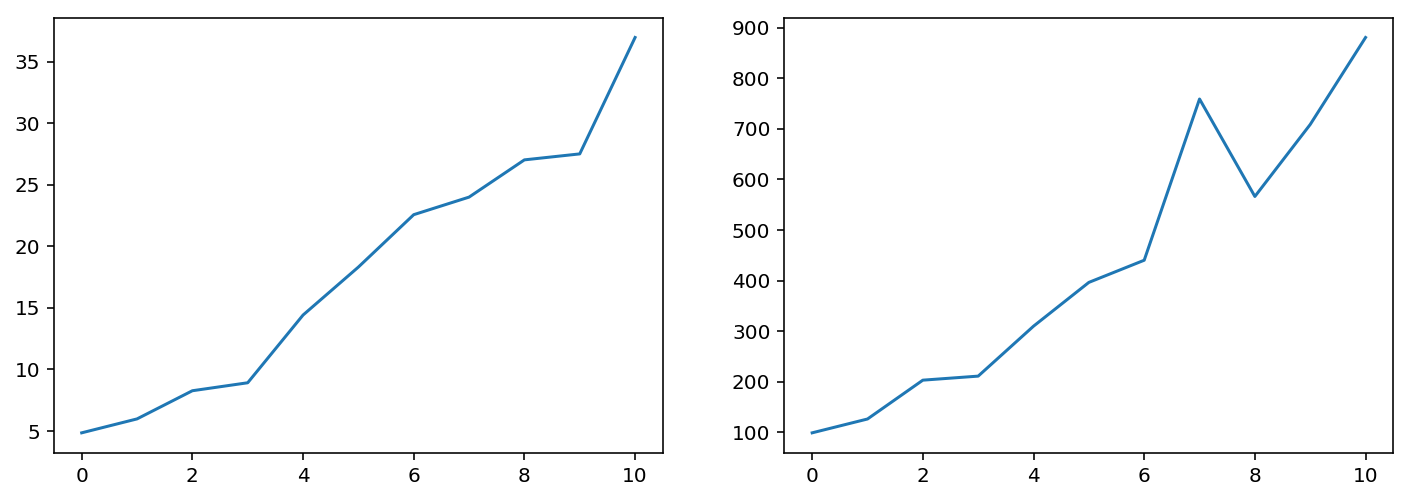

In [79]:
lst = []
aics=[]
bics=[]
logprobs =[ ]
from sklearn.model_selection import train_test_split
train, test = train_test_split(latent3000.z_mu.numpy())
for i in range(1,12):
    mix = GaussianMixture(n_components=i)
    mix.fit(latent3000.z_mu.numpy())
    
    
    mix_dist = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=mix.weights_),
    #components_distribution=tfd.MultivariateNormalDiag(
    #    loc=mix.means_, scale_identity_multiplier=mix.covariances_)
    #components_distribution=tfd.MultivariateNormalDiag(
    #    loc=mix.means_, scale_diag=mix.covariances_)
    components_distribution=tfd.MultivariateNormalFullCovariance(
        loc=mix.means_, covariance_matrix=mix.covariances_))
    
    
    lst.append(mix.lower_bound_)
    aics.append(mix.aic(test))
    bics.append(mix.bic(test))
    logprobs.append(tf.reduce_sum(mix_dist.log_prob(test)))
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(lst)
plt.subplot(122)
plt.plot(logprobs);

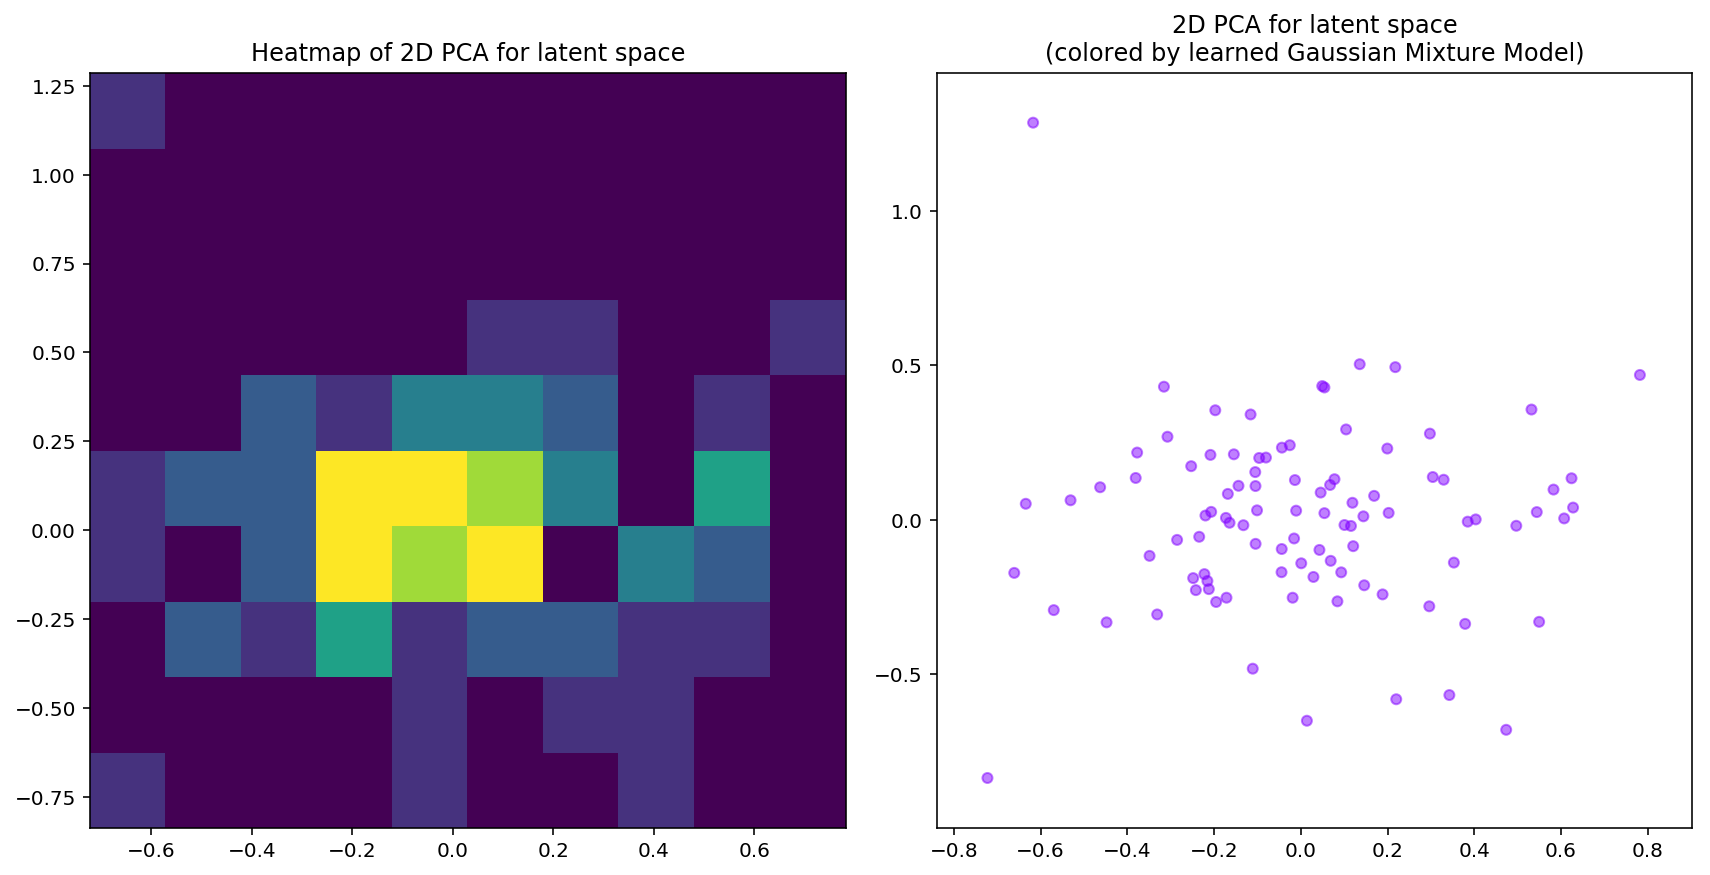

In [81]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.hist2d(pca_mu[:,0], pca_mu[:,1], bins=10)
plt.title('Heatmap of 2D PCA for latent space')

plt.subplot(122)
plt.scatter(pca_mu[:,0], pca_mu[:,1],
            c=assign_samp, 
            cmap='rainbow', s=25, alpha=0.5)

plt.scatter(pca_mu[:,0], pca_mu[:,1],
            c=assign_samp, 
            cmap='rainbow', 
            s=1000*np.square(np.mean(latent3000.z_sigma.numpy(),axis=1)), alpha=0.0001,)

plt.tight_layout()
plt.title('2D PCA for latent space\n(colored by learned Gaussian Mixture Model)');

### Factor loadings of latent space 1

In [73]:
mean_latent_vector = (
    pd.concat(
    [pd.DataFrame({'cluster':assign_samp}),
    pd.DataFrame(latent3000.z_mu.numpy())], 
    axis=1)
    .groupby('cluster')
    .mean())

In [74]:
mean_latent_vector

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
cluster,,,,,,,,,,,,,,,,
0,0.014575,0.049840,0.070544,-0.027304,-0.045260,-0.014999,0.082933,0.001811,0.074962,-0.022318,-0.010592,-0.007300,-0.076735,-0.069436,-0.025672,0.000522
1,-0.027483,-0.119561,-0.077924,0.065531,0.049723,0.027419,-0.125898,0.019322,-0.043224,0.064992,-0.035746,0.009329,0.184966,0.125503,0.167361,-0.028035


In [75]:
[x.shape for x in latent3000.get_weights()]

[(53, 128),
 (128, 1024),
 (256, 1024),
 (1024,),
 (256, 1024),
 (256, 1024),
 (1024,),
 (280, 256),
 (256,),
 (280, 53),
 (53,),
 (96, 16),
 (96, 16),
 (3, 8),
 (3, 8),
 (96, 16),
 (96, 16),
 (3, 8),
 (3, 8)]

In [76]:
mean_latent_vector.shape

(2, 16)

In [374]:
#latent3000.get_weights()[-6][-16:].shape

In [376]:
latent3000.get_weights()[-2].shape

(190, 62)

In [378]:
cluster_y_dist = tf.nn.softmax(
    (mean_latent_vector
    @ latent3000.get_weights()[-6][-16:]).values, 
    axis=1)

ValueError: Dot product shape mismatch, (2, 62) vs (190, 62)

In [378]:
cluster_y_dist = tf.nn.softmax(
    (mean_latent_vector
    @ latent3000.get_weights()[-2]).values, 
    axis=1)

ValueError: Dot product shape mismatch, (2, 62) vs (190, 62)

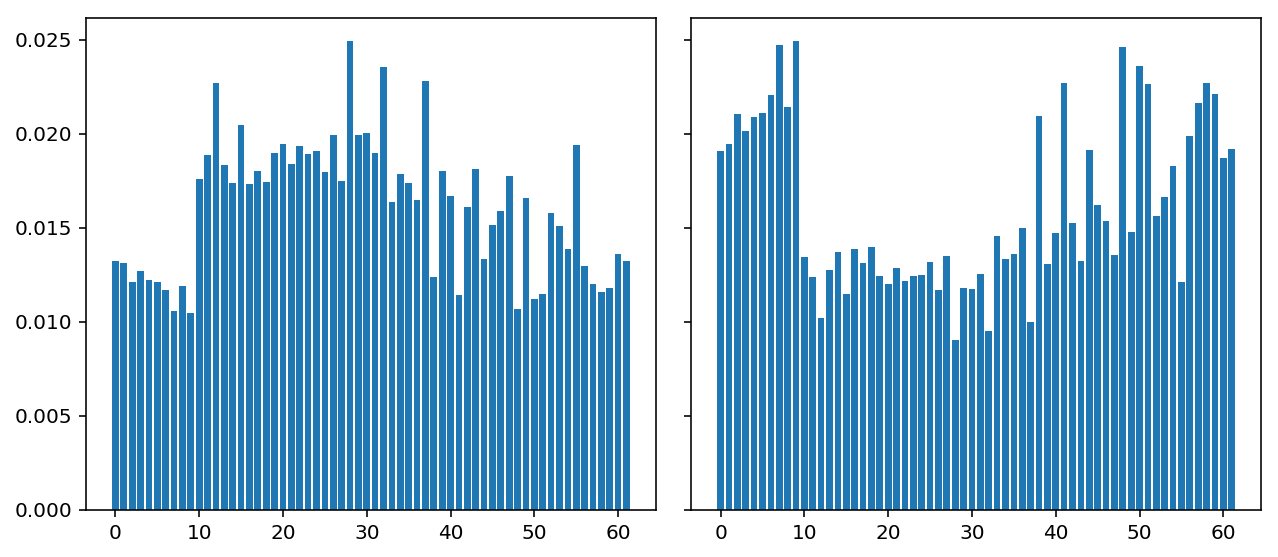

In [295]:
fig, axes = plt.subplots(1,2,figsize=(9,4), sharey=True)
for i in range(2):
    axes[i].bar(range(62),cluster_y_dist[i])
plt.tight_layout();

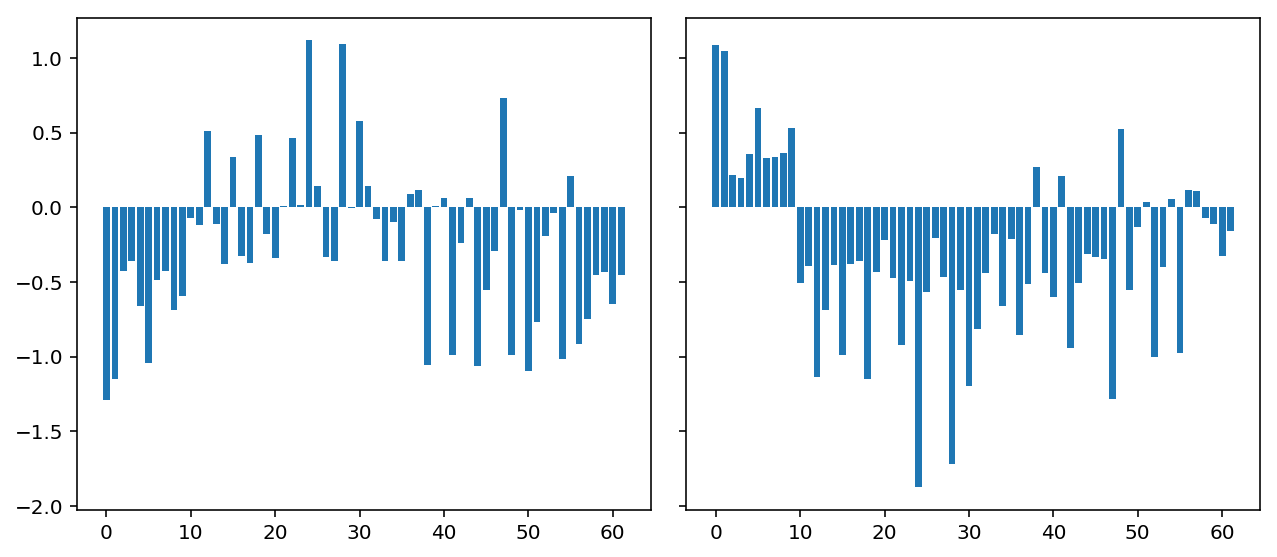

In [379]:
fig, axes = plt.subplots(1,2,figsize=(9,4), sharey=True)
for i in range(2):
    axes[i].bar(range(62),mean_latent_vector.loc[i].values)
plt.tight_layout();

### latent var 2

In [89]:
from sklearn.decomposition import PCA
pca2 = PCA(n_components=2)
pca_mu2 = pca.fit_transform(latent3000.z3_mu.numpy())
pca2 = PCA(n_components=2)
pca_sigma2 = pca.fit_transform(latent3000.z3_sigma.numpy())

In [90]:
from sklearn.mixture import GaussianMixture

mix2 = GaussianMixture(n_components=1, covariance_type='full')
mix2.fit(latent3000.z3_mu.numpy())

mix2_dist = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=mix2.weights_),
    #components_distribution=tfd.MultivariateNormalDiag(
    #    loc=mix.means_, scale_identity_multiplier=mix.covariances_)
    #components_distribution=tfd.MultivariateNormalDiag(
    #    loc=mix.means_, scale_diag=mix.covariances_)
    components_distribution=tfd.MultivariateNormalFullCovariance(
loc=mix2.means_, covariance_matrix=mix2.covariances_));

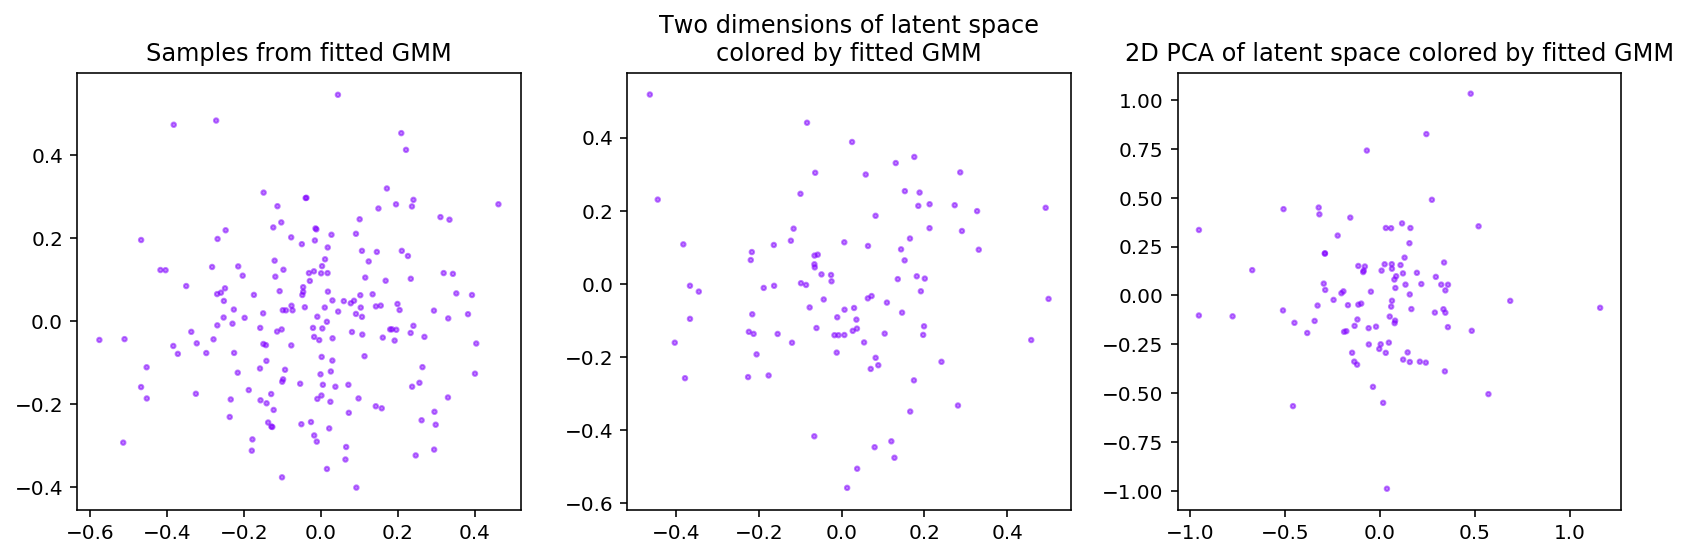

In [92]:
plt.figure(figsize=(12,4))
plt.subplot(131)

mix2_samp = mix2_dist.sample(190)
assign_samp = tfd.Categorical(probs=mix2.predict_proba(mix2_samp)).sample().numpy()
plt.scatter(mix2_samp[:,1], mix2_samp[:,0], s=5, 
           c=assign_samp, cmap='rainbow', alpha=0.5)
plt.title('Samples from fitted GMM')

plt.subplot(132)
z_space = latent3000.z3_mu.numpy()
assign_samp = tfd.Categorical(probs=mix2.predict_proba(z_space)).sample().numpy()
plt.scatter(z_space[:,0], z_space[:,1], s=5, 
           c=assign_samp, cmap='rainbow', alpha=0.5)
plt.title('Two dimensions of latent space\ncolored by fitted GMM')

plt.subplot(133)
z_space = pca_mu2
plt.scatter(z_space[:,0], z_space[:,1], s=5, 
           c=assign_samp, cmap='rainbow', alpha=0.5)
plt.title('2D PCA of latent space colored by fitted GMM')
plt.tight_layout();

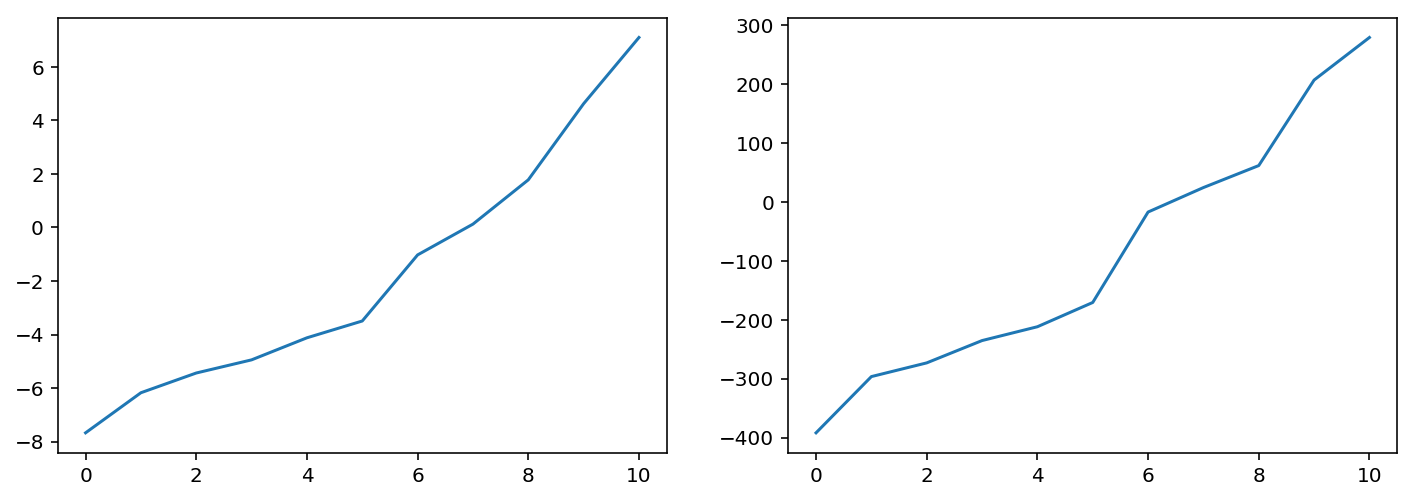

In [298]:
lst = []
aics=[]
bics=[]
logprobs =[ ]
from sklearn.model_selection import train_test_split
train, test = train_test_split(latent3000.z2_mu.numpy())
for i in range(1,12):
    mix2 = GaussianMixture(n_components=i)
    mix2.fit(latent3000.z2_mu.numpy())
    
    
    mix2_dist = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=mix2.weights_),
    #components_distribution=tfd.MultivariateNormalDiag(
    #    loc=mix.means_, scale_identity_multiplier=mix.covariances_)
    #components_distribution=tfd.MultivariateNormalDiag(
    #    loc=mix.means_, scale_diag=mix.covariances_)
    components_distribution=tfd.MultivariateNormalFullCovariance(
        loc=mix2.means_, covariance_matrix=mix2.covariances_))
    
    
    lst.append(mix2.lower_bound_)
    aics.append(mix2.aic(test))
    bics.append(mix2.bic(test))
    logprobs.append(tf.reduce_sum(mix2_dist.log_prob(test)))
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(lst)
plt.subplot(122)
plt.plot(logprobs);

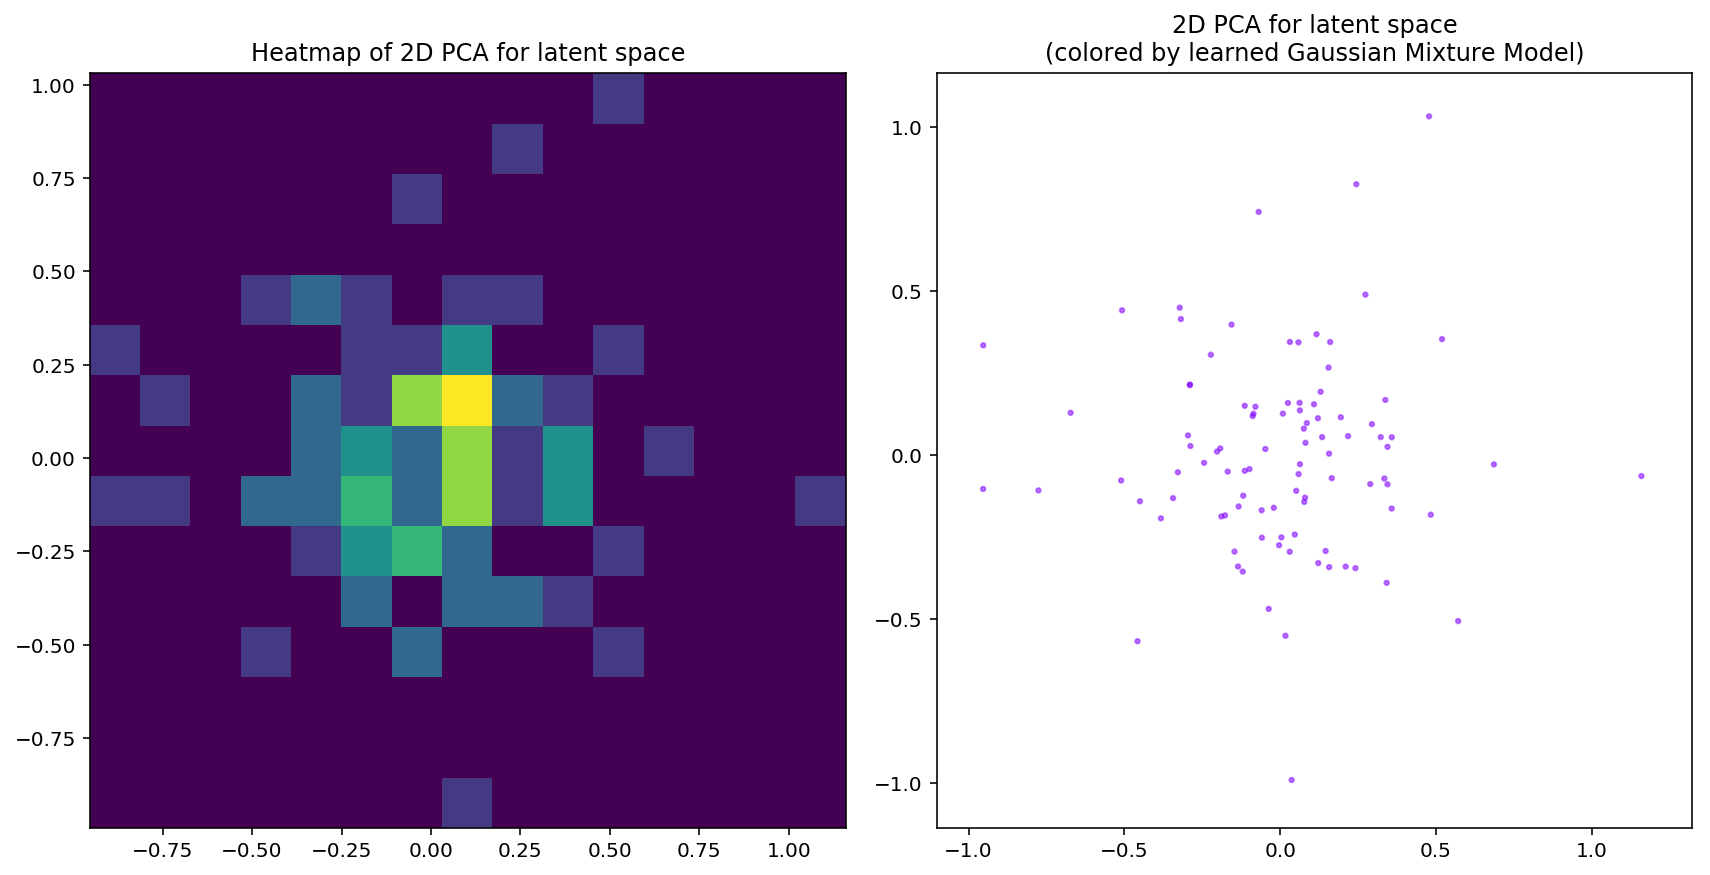

In [93]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.hist2d(pca_mu2[:,0], pca_mu2[:,1], bins=15)
plt.title('Heatmap of 2D PCA for latent space')

plt.subplot(122)
plt.scatter(pca_mu2[:,0], pca_mu2[:,1],
            c=assign_samp, 
            cmap='rainbow', s=5, alpha=0.5)

plt.scatter(pca_mu2[:,0], pca_mu2[:,1],
            c=assign_samp, 
            cmap='rainbow', 
            s=1000*np.square(np.mean(latent3000.z_sigma.numpy(),axis=1)), alpha=0.0001,)

plt.tight_layout()
plt.title('2D PCA for latent space\n(colored by learned Gaussian Mixture Model)');

### Factor loadings of latent space

In [300]:
mean_latent_vector = (
    pd.concat(
    [pd.DataFrame({'cluster':assign_samp}),
    pd.DataFrame(latent3000.z2_mu.numpy())], 
    axis=1)
    .groupby('cluster')
    .mean())

In [301]:
[x.shape for x in latent3000.get_weights()]

[(3, 3, 1, 16),
 (16,),
 (3, 3, 16, 32),
 (32,),
 (1584, 256),
 (256,),
 (272, 62),
 (62,),
 (190, 16),
 (190, 16),
 (190, 16),
 (190, 16)]

In [302]:
mean_latent_vector.shape

(3, 16)

In [303]:
latent3000.get_weights()[-8][-16:].shape

(16, 256)

In [304]:
cluster_y_dist = tf.nn.softmax(
    (mean_latent_vector
    @ latent3000.get_weights()[-8][-16:]).values, 
    axis=1)

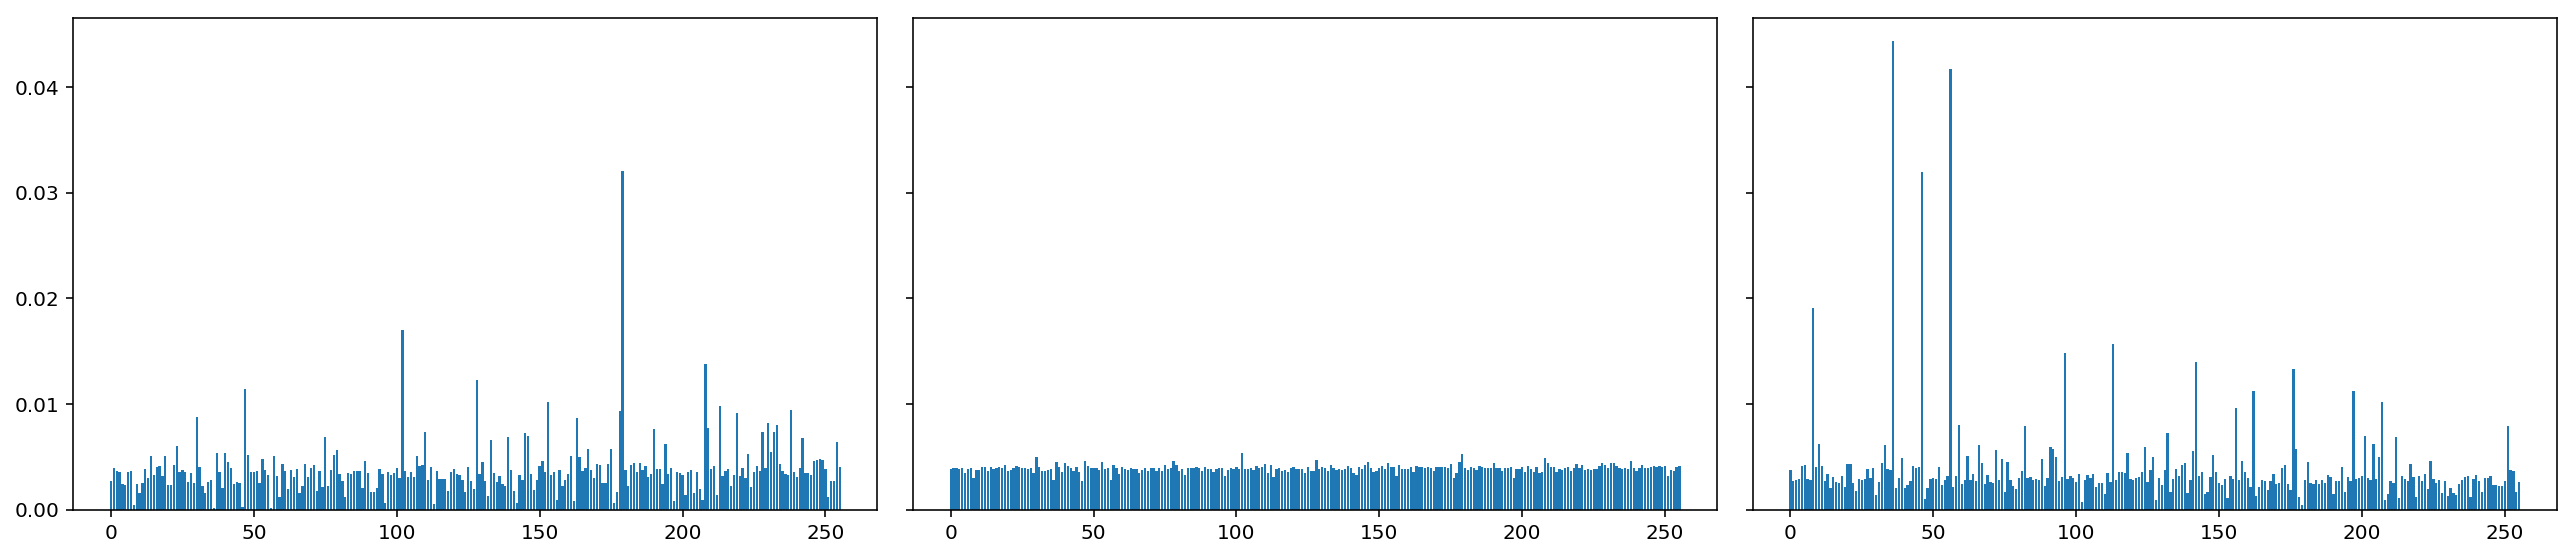

In [305]:
fig, axes = plt.subplots(1,3,figsize=(18,4), sharey=True)
for i in range(3):
    axes[i].bar(range(256),cluster_y_dist[i][:256])
plt.tight_layout();

## Sampling

In [66]:
labels = list(string.digits +  string.ascii_uppercase + string.ascii_lowercase)
labels_dict = {i: labels[i] for i in range(62)}
num2label = lambda arr: list(map(lambda x: labels_dict[x], arr))

In [55]:
##potentially expensive
#num2label(latent3000(x_test, gid_test).numpy().argmax(axis=1))[:10]

In [146]:
tf.round(tf.reduce_sum(tf.exp(
    latent3000.call_sample_z(x_test[:100], gid_test[:100], num_samples=20)[1]), axis=0), 2)

<tf.Tensor: id=5925, shape=(100,), dtype=float32, numpy=
array([2.0000000e+01, 1.2730000e+03, 2.5000000e+01, 2.0000000e+01,
       2.0000000e+01, 2.1000000e+01, 2.0000000e+01, 2.0000000e+01,
       6.6000000e+01, 2.0000000e+01, 2.2000000e+01, 2.0000000e+01,
       2.1000000e+01, 2.0000000e+01, 2.0000000e+01, 2.0000000e+01,
       2.1000000e+01, 2.0000000e+01, 2.0000000e+01, 2.0000000e+01,
       2.0000000e+01, 2.0000000e+01, 2.0000000e+01, 2.0000000e+01,
       2.0000000e+01, 2.0000000e+01, 2.0000000e+01, 2.0000000e+01,
       2.0000000e+01, 2.0000000e+01, 2.0000000e+01, 2.1000000e+01,
       2.0000000e+01, 2.0000000e+01, 2.5000000e+01, 4.5829232e+07,
       2.0000000e+01, 2.0000000e+01, 2.0000000e+01, 2.0000000e+01,
       2.5000000e+01, 2.0000000e+01, 2.1000000e+01, 1.8154760e+11,
       2.0000000e+01, 2.0000000e+01, 2.0000000e+01, 2.0000000e+01,
       2.0000000e+01, 2.0000000e+01, 2.0000000e+01, 2.0661435e+20,
       3.5000000e+01, 2.0000000e+01, 2.1000000e+01, 2.0000000e+01,
     

In [76]:
#potentially expensive
samp = latent3000.call_sample_z(x_test[:100], gid_test[:100], num_samples=20)

AttributeError: 'LatentLSTM' object has no attribute 'reshape'

In [148]:
logits, importance_weights = samp
numerator = (
    tf.reduce_sum(tf.nn.softmax(logits) * tf.expand_dims(importance_weights, axis=2), axis=0))
imp_weight_sum = np.expand_dims(tf.reduce_sum(importance_weights, axis=0), axis=1)
samp_imp = numerator / imp_weight_sum

In [167]:
importance_weights

<tf.Tensor: id=6273, shape=(20, 10000), dtype=float32, numpy=
array([[6.16289897e-13, 6.15191620e-10, 5.50418198e-02, ...,
        4.83401031e+01, 1.15584364e-04, 1.04596058e-03],
       [2.96137482e-03, 2.12884438e-03, 2.44116632e-06, ...,
        2.65484571e-01, 3.49417776e-01, 1.25571474e-04],
       [8.81246615e-06, 9.65459913e-05, 7.79067874e-02, ...,
        3.61654784e-05, 1.86451143e-04, 1.35878350e-10],
       ...,
       [1.46515388e-03, 3.79739672e-01, 1.09745981e-08, ...,
        4.14538008e-05, 1.50837877e-04, 6.65016269e-05],
       [1.92664484e-09, 2.26468754e+01, 6.96879521e-04, ...,
        1.69363852e-06, 4.69121151e-03, 7.43775945e-06],
       [1.09371982e-07, 3.87753414e-12, 8.78692247e-13, ...,
        2.66723350e-06, 4.89697415e-11, 4.84131033e-06]], dtype=float32)>

In [170]:
tf.round(importance_weights, 5).numpy().max(axis=1)

array([ 554., 2321.,  716., 2528., 1289., 1225.,  688., 1617.,  838.,
       2092., 3029.,  760., 5334., 5455.,  457., 4900., 2262.,  616.,
       3175.,  359.], dtype=float32)

In [169]:
tf.round(importance_weights, 5).numpy().mean(axis=1)

array([0.4119, 0.6447, 0.4105, 0.6507, 0.5331, 0.7933, 0.4095, 0.4858,
       0.3703, 0.6278, 0.6862, 0.4477, 1.5514, 1.1082, 0.459 , 0.8155,
       0.6028, 0.5665, 1.0055, 0.4723], dtype=float32)

<BarContainer object of 62 artists>

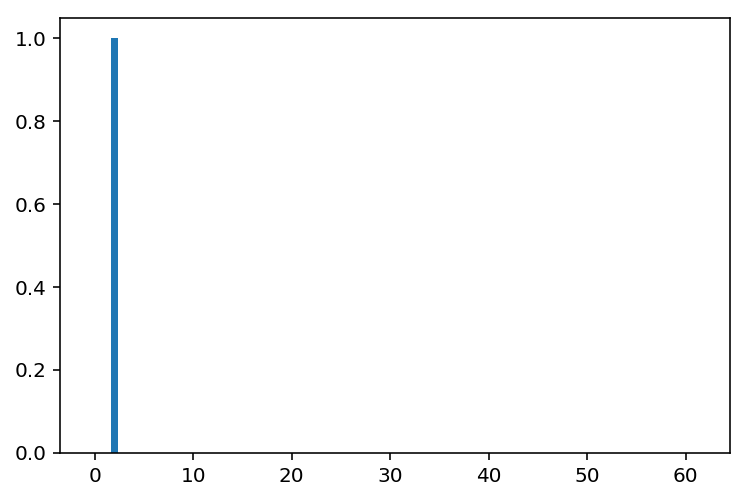

In [149]:
plt.bar(range(62), samp_imp[0])

In [ ]:
z_samp = latent3000.construct_mean_field_posterior(4).sample(20)

In [61]:
p_y_giv_xz = latent3000.call_sample_z(x_train[:100], gid_train[:100], num_samples=20)

In [ ]:
def get_k_largest_elements(arr, k):
    return arr[np.argpartition]

In [150]:
tf.reduce_mean(samp.numpy(), axis=0)[0]

AttributeError: 'tuple' object has no attribute 'numpy'

In [ ]:
#.apply(num2label)

In [ ]:
#'1':np.partition(row, -4)[-4:]}

In [93]:

softmax_out = tf.nn.softmax(tf.reduce_mean(samp[0], axis=0), axis=1).numpy()[:1000]

In [151]:
def sorted_argpartition():
    pass
    

argpart = np.apply_along_axis(lambda row: np.argpartition(row, np.arange(-4,-1))[-4:][::-1], 1, 
                              samp_imp)
values = np.apply_along_axis(lambda row: np.sort(row)[-4:][::-1], 1, samp_imp)
softmax_df = pd.concat([
    pd.DataFrame(argpart).stack().rename('label_index'), 
    pd.DataFrame(values).stack().rename('softmax')], axis=1)

softmax_df['label_index'] = softmax_df[['label_index']].apply(num2label)
softmax_df = softmax_df.reset_index(level=1,drop=True).set_index('label_index', append=True)['softmax']
softmax_df = softmax_df.round(2)[softmax_df > 0.01]

In [152]:
(softmax_df.loc[np.random.choice(range(1000), size=10)]
 .groupby(level=0)
 .filter(lambda s: len(s) > 1)).head(20)

     label_index
51   X              0.94
     x              0.06
181  I              0.36
     1              0.34
     i              0.19
     l              0.11
437  1              0.84
     l              0.15
     I              0.02
463  6              0.60
     0              0.32
     g              0.07
540  0              0.92
     O              0.07
703  1              0.82
     l              0.10
     I              0.07
     i              0.01
Name: softmax, dtype: float32

In [329]:
(pd.DataFrame(
    tf.nn.softmax(tf.reduce_mean(samp.numpy(), axis=0)))
 .T.apply(num2label).stack()
 .groupby(level=0)
 .value_counts(normalize=True)).groupby(level=0).size().value_counts()

KeyboardInterrupt: 

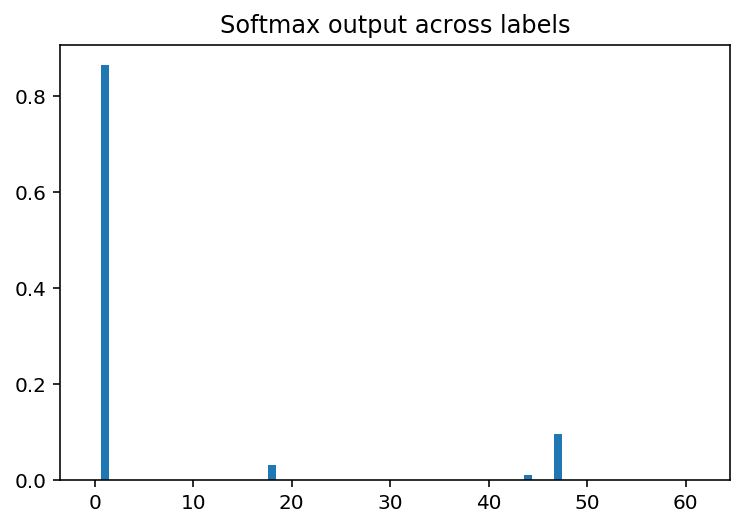

In [158]:
plt.bar(range(62),tf.nn.softmax(tf.reduce_mean(samp.numpy(), axis=0)[10]))
plt.title('Softmax output across labels');

In [117]:
uncertainty_df = (pd.DataFrame(
    samp.numpy().argmax(axis=2))
 .T.apply(num2label).stack()
 .groupby(level=0)
 .value_counts(normalize=True))

(uncertainty_df.loc[np.random.choice(range(10000), size=100)]
 .groupby(level=0)
 .filter(lambda s: len(s) > 1))

AttributeError: 'tuple' object has no attribute 'numpy'

label_index
6    0.60
0    0.32
g    0.07
Name: softmax, dtype: float32


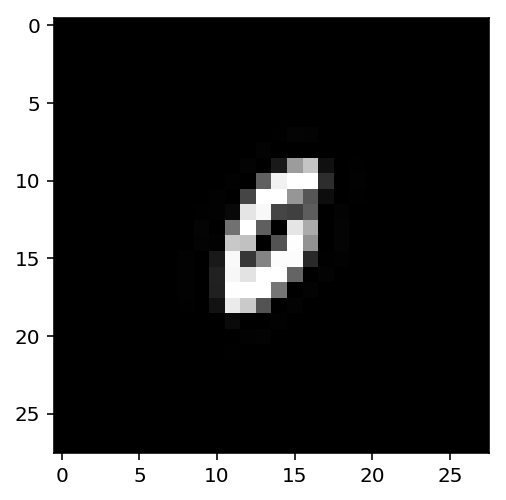

In [154]:
idx=463
print(softmax_df.loc[idx])
plt.imshow(
    x_test[idx].reshape((28,28)), 
    cmap='Greys');

### Calibration test

In [155]:
plt.hist(tf.nn.softmax(tf.reduce_mean(samp, axis=0)).numpy()[:1000].max(axis=1), bins=30);

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [20,10000,62] != values[1].shape = [20,10000] [Op:Pack] name: packed

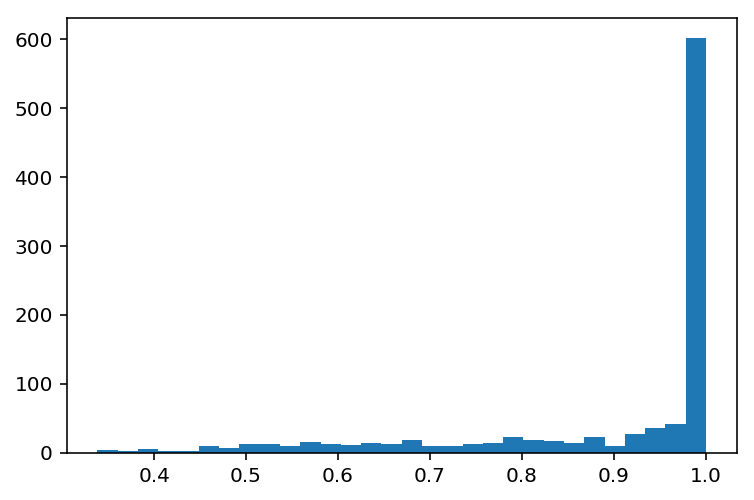

In [164]:
plt.hist(samp_imp.numpy()[:1000].max(axis=1), bins=30);

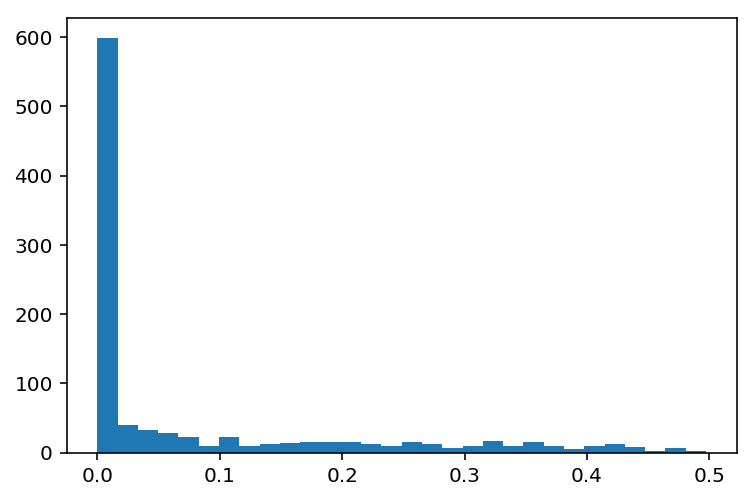

In [165]:
plt.hist(np.partition(samp_imp.numpy()[:1000], -2, axis=1)[:,-2], bins=30);

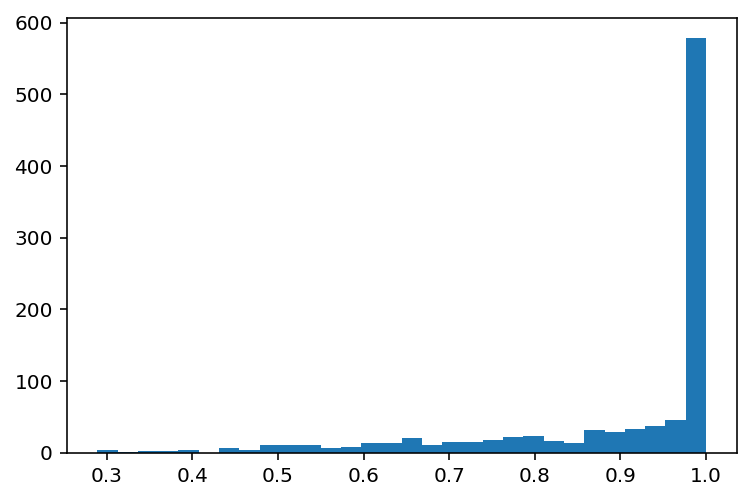

In [151]:
plt.hist(tf.nn.softmax(latent3000(x_test[:1000], gid_test[:1000])).numpy().max(axis=1), bins=30);

In [156]:
calib_df = pd.concat([
    pd.Series(tf.nn.softmax(tf.reduce_mean(samp, axis=0)).numpy()[:1000].max(axis=1)),
    pd.Series(tf.nn.softmax(tf.reduce_mean(samp, axis=0)).numpy()[:1000].argmax(axis=1)),
          pd.Series(y_test[:1000].argmax(axis=1))], axis=1)

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [20,10000,62] != values[1].shape = [20,10000] [Op:Pack] name: packed

In [158]:
calib_df = pd.concat([
    pd.Series(samp_imp.numpy().max(axis=1)),
    pd.Series(samp_imp.numpy().argmax(axis=1)),
          pd.Series(y_test.argmax(axis=1))], axis=1)

In [234]:
calib_df = pd.concat([
    pd.Series(tf.nn.softmax(latent3000(x_test[:1000], gid_test[:1000])).numpy().max(axis=1)),
    pd.Series(tf.nn.softmax(latent3000(x_test[:1000], gid_test[:1000])).numpy().argmax(axis=1)),
          pd.Series(y_test[:1000].argmax(axis=1))], axis=1)

In [162]:
from sklearn.metrics import accuracy_score

In [160]:
stretch_range = lambda x: 1-np.log(1-x)
stretch_range_inv = lambda x: 1-np.exp(1-x)

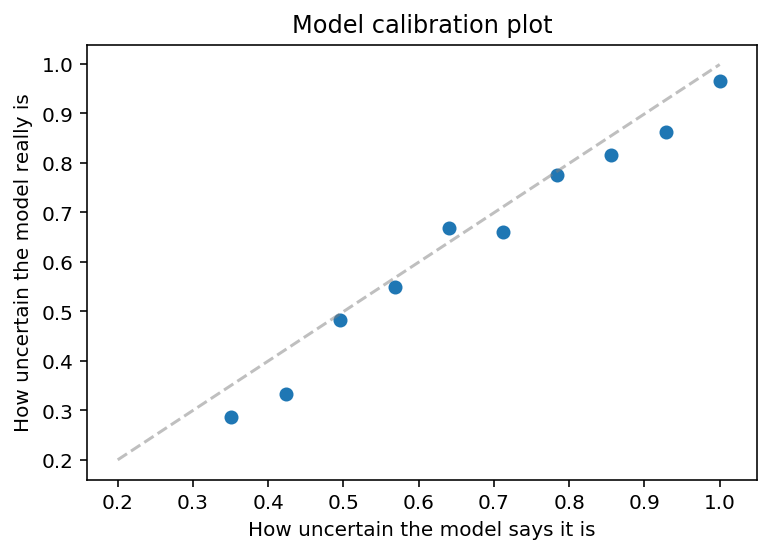

In [163]:
calib_df['calib_bin'] = (
    pd.cut(calib_df[0], bins=10)
    .apply(lambda x: x.right))
calib = (calib_df.groupby('calib_bin')
         .apply(lambda df: accuracy_score(df[2], df[1]))
         .reset_index())
plt.scatter(calib.values[:,0], calib.values[:,1])
plt.plot(np.linspace(0.2,1,2), np.linspace(0.2,0.999,2), alpha=0.5, color='grey', linestyle='dashed')
plt.title('Model calibration plot')
plt.xlabel('How uncertain the model says it is')
plt.ylabel('How uncertain the model really is');

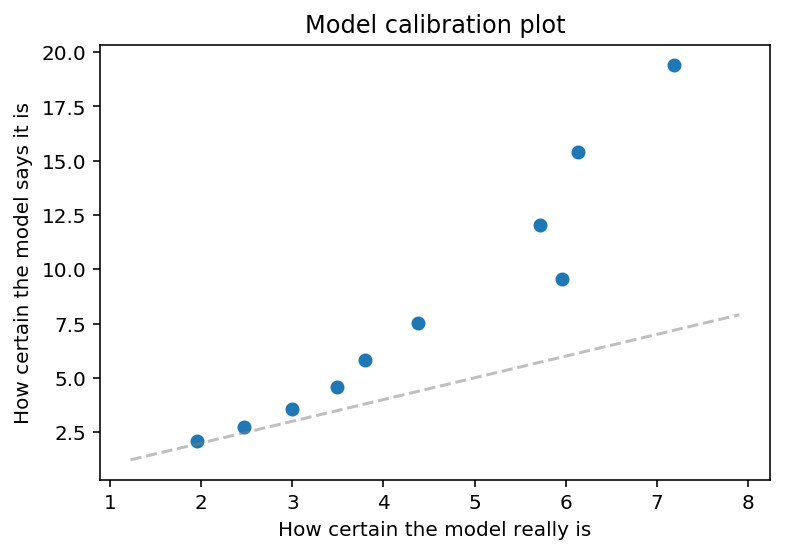

In [201]:
calib_df['calib_bin'] = (
    pd.qcut(stretch_range(calib_df[0]-0.00000001), q=10)
    .apply(lambda x: x.right))
calib = (calib_df.groupby('calib_bin')
         .apply(lambda df: stretch_range(accuracy_score(df[2], df[1]))-0.00000001)
         .reset_index())
plt.scatter(calib.values[:,1], calib.values[:,0])
plt.plot( stretch_range(np.linspace(0.2,0.999,2)), stretch_range(np.linspace(0.2,0.999,2)), alpha=0.5, color='grey', linestyle='dashed' )
plt.title('Model calibration plot')
plt.ylabel('How certain the model says it is')
plt.xlabel('How certain the model really is');